### Import

In [1]:
from music_classifier_utils import Cutter, Loader, MusicClassifier, MusicFeaturesExtractor, genres
from musicnet_utils import features
import musicnet_utils

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import IPython
import librosa
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib import pyplot as plt
from warnings import filterwarnings, resetwarnings
from multiprocessing import Pool
import joblib
from copy import deepcopy
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss
import seaborn as sns
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from tqdm.notebook import tqdm

SEED = int(1e9+7e7+17)

def seed_init():
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

seed_init()
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=np.VisibleDeprecationWarning)
filterwarnings("ignore", category=UserWarning)
n_jobs=os.cpu_count()
# filterwarnings("ignore")

### hist, plot

In [4]:
def plot(*args, title='', xlabel='', ylabel='', **kwargs):
    plt.figure(figsize=(18,5))
    plt.plot(*args, **kwargs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def hist(*args, **kwargs):
    plt.figure(figsize=(18,5))
    plt.hist(*args, **kwargs)
    plt.show()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:",torch.cuda.get_device_name(device.index) if device.type=="cuda" else device.type)

Device: Tesla P100-PCIE-16GB


### global parameters

In [6]:
n_input = 57
n_output = 10

### Activator, Kernel

In [7]:
class Activator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.pow(torch.add(x,1),3)
    
class Kernel(torch.nn.Module):
    def __init__(self, n_input:int, n_output:int, gamma:float=1):
        super().__init__()
        self.n_input, self.n_output = n_input, n_output
        tmp=torch.nn.Linear(self.n_input, self.n_output)
        self.weight = torch.nn.Parameter(data=tmp.weight)
        self.bias = torch.nn.Parameter(data=tmp.bias)
#         self.weight = torch.nn.Parameter(data=torch.randn((self.n_output, self.n_input), dtype=torch.float, device=device))
#         self.bias = torch.nn.Parameter(data=torch.randn((self.n_output), dtype=torch.float, device=device))
#         self.gamma = torch.nn.Parameter(data=torch.tensor([1], dtype=torch.float))
        self.gamma=gamma
        
    def forward(self, input: torch.Tensor) -> torch.Tensor:
#         x = torch.nn.functional.linear(input, self.weight, self.bias)
#         return x
#         return torch.pow(torch.add(x,1),3)
        n,m,k = input.shape[0], self.n_input, self.n_output
        ones = torch.ones((n, k, m), dtype=torch.float, device=device)
        distances = torch.sum(
            torch.pow(
                (torch.matmul
                (ones, torch.diag_embed(input))
                 - self.weight.expand(n,k,m)),
                  2),
                   dim=2)
        return torch.exp(-self.gamma*distances)-self.bias

### ClassifierNet

In [8]:
class ClassifierNet(torch.nn.Module):
    def __init__(self, n_input:int=n_input, n_output:int=n_output, n_hidden=[256,128,64], dropout=0.1, act='elu')->None:
        super(ClassifierNet, self).__init__()
        self.encoder = LabelEncoder()
        self.encoder.fit(genres)
        
        params = {'n_input':n_input, 'n_output':n_output, 'n_hidden':n_hidden, 'dropout':dropout, 'act':act}
        self.model = self.sequential(**params)
        params['n_output'] = 1
        self.models = torch.nn.ModuleList([self.sequential(**params) for i in range(10)])
        
    def sequential(self, n_input:int=n_input, n_output:int=n_output, n_hidden=[256,128,64], dropout=0.0, act='elu'):

        act = torch.nn.ELU if act == 'elu' else torch.nn.ReLU

        seq = torch.nn.Sequential(        
            torch.nn.Linear(n_input, n_hidden[0]),
#             Kernel(n_input, n_hidden[0]),
            torch.nn.BatchNorm1d(n_hidden[0]),
            torch.nn.Dropout(p=dropout),
            act(),

            torch.nn.Linear(n_hidden[0], n_hidden[1]),
#             Kernel(n_hidden[0], n_hidden[1]),
            torch.nn.BatchNorm1d(n_hidden[1]),
            torch.nn.Dropout(p=dropout),
            act(),

            torch.nn.Linear(n_hidden[1], n_hidden[2]),
#             Kernel(n_hidden[1], n_hidden[2]),
            torch.nn.BatchNorm1d(n_hidden[2]),
            torch.nn.Dropout(p=dropout),
            act(),

            torch.nn.Linear(n_hidden[2], n_output),
#             Kernel(n_hidden[2], n_output),
#             torch.nn.BatchNorm1d(n_output),
#             act(),
        )
        return seq
    
    def get_weights(self, weights, n_input, lb, ub):
        return torch.nn.parameter.Parameter((weights/np.sqrt(1/n_input)+1)/2*(ub-lb)+lb, requires_grad=True)
        
    def forward(self, x, x_frequencies=None):
        if len(x.shape)==1:
            x = x.reshape(1,-1)
        x = self.model(x)
#         x = torch.cat([self.models[i](x) for i in range(10)], dim=1)
        
        return x
    
    def predict_proba(self, x):
        if isinstance(x, pd.DataFrame):
            x = torch.tensor(x.values, dtype=torch.float, device=device)
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float, device=device)
            
        sm = torch.nn.Softmax()
        if not self.training:
            x = torch.utils.data.TensorDataset(x)
            generator = torch.utils.data.DataLoader(x, batch_size=100, shuffle=False, drop_last=False)
            x = torch.cat([self.forward(X_batch).data for (X_batch,) in generator], dim=0)
            return sm(x)
        return sm(self.forward(x))
    
    def predict_index(self, x):
        return torch.tensor(self.predict_proba(x).argmax(axis=1), device=device)
    
    def predict(self, x):
        return self.encoder.inverse_transform(self.predict_index(x).cpu())
    
    def fit(self, X_train, y_train, X_test, y_test, train_minutes=1, verbose=1, verbose_interval=200, opt_params=None,
           sched_params=None, epochs=100, batch_size=None):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        train_loss_history = []
        test_loss_history = []
        test_acc_history = []
        self.best_loss = None
        self.best_params = None
        
        y_train = self.encoder.transform(y_train)
        y_test = self.encoder.transform(y_test)

        order_train = [i for i in range(X_train.shape[0])]
        order_test = [i for i in range(X_test.shape[0])]

        if batch_size is None:
            batch_size = X_train.shape[0]//40
#             batch_size = 128

        self.to(device)
        loss = torch.nn.CrossEntropyLoss()
        X_train = X_train.to(device)
        y_train = torch.tensor(y_train).to(device)
        X_test = X_test.to(device)
        y_test = torch.tensor(y_test).to(device)
        train_data = torch.utils.data.TensorDataset(X_train, y_train)
        test_data = torch.utils.data.TensorDataset(X_test, y_test)

    #     train_speed = 17/200*60 #epochs per minute
        train_speed = 2104/26.8*60
#         epochs = int(train_minutes*train_speed)
        
        if opt_params is None:
            opt_params = dict(lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        if sched_params is None:
            sched_params = dict(milestones=[20,70], gamma=0.1)
        optimizer = torch.optim.Adam(self.parameters(), **opt_params)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, **sched_params)
        
        for epoch in tqdm(range(epochs)):
            generator = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
            self.train()
            torch.cuda.empty_cache()
            for X_batch, y_batch in generator:
                optimizer.zero_grad()

                preds = net.forward(X_batch)
                loss_value = loss(preds, y_batch)
                train_loss_history.append(loss_value.data.cpu())
                loss_value.backward()

                optimizer.step()
                scheduler.step()

            self.eval()
            generator = torch.utils.data.DataLoader(test_data, batch_size=min(X_test.shape[0],batch_size), 
                                                    shuffle=True, drop_last=True)
            test_results = []
            test_results_acc = []
            for X_batch, y_batch in generator:

                with torch.no_grad():
                    test_preds = self.forward(X_batch)
                test_results.append(loss(test_preds, y_batch).data.cpu())
                test_results_acc.append(accuracy_score(y_batch.cpu(), test_preds.argmax(axis=1).cpu()))

            test_loss_history.append(sum(test_results)/len(test_results))
            test_acc_history.append(sum(test_results_acc)/len(test_results_acc))
            
            if(verbose==1 and (epoch+1)%verbose_interval==0):
                print(train_loss_history[-1].item(), test_loss_history[-1].item())
                
            if(self.best_loss is None or test_loss_history[-1] < self.best_loss):
                self.best_loss = test_loss_history[-1]
                self.best_params = {'net_state_dict': self.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'loss': self.best_loss}


        return (train_loss_history, test_loss_history, test_acc_history)

### Features generation

In [9]:
# %%time
# extractor = MusicFeaturesExtractor()
# cutter = Cutter()
# loader = Loader()

# dataset = loader.load_tracks('../input/gtzan-dataset-music-genre-classification/Data/genres_original')
# dataset, labels = cutter.cut_dataset(dataset, [5,10,15], n_jobs=n_jobs, default_labels=musicnet_utils.default_labels)
# print(dataset.shape, len(labels))

# X = extractor.extract(dataset)
# Y = np.array(labels.copy())

# output_features = pd.concat([X,pd.DataFrame(Y)], axis=1)
# output_features.columns = features + ["label"]
# output_features.to_csv('./features_5_10_15.csv', index=False)

In [10]:
rfc = joblib.load('../input/musicclassifier/MusicClassifier.rfc')

In [11]:
package = MusicClassifier()
MusicClassifier.__module__="music_classifier_utils"
joblib.dump(package, './MusicClassifier.spgn', compress=True)

['./MusicClassifier.spgn']

In [12]:
%%time
extractor = MusicFeaturesExtractor()
cutter = Cutter()
loader = Loader()

net = package(os.cpu_count())
# net.predict_proba_display(X_path = "../input/musicpack2")

CPU times: user 72.4 ms, sys: 64.3 ms, total: 137 ms
Wall time: 136 ms


### X_train_, y_train_, X_test_, y_test_

In [13]:
%%time
# extractor = MusicFeaturesExtractor()
# cutter = Cutter()
# loader = Loader()

# data = loader.load_tracks('../input/gtzan-dataset-music-genre-classification/Data/genres_original')
# default_labels = musicnet_utils.default_labels
# data, labels = cutter.cut_dataset(data, [-1], n_jobs=n_jobs, default_labels=default_labels)
# print(data.shape, len(labels))
    
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=SEED, shuffle=True)

# X_train, y_train = cutter.cut_dataset(X_train, [-1, -1/2, -1/4, -1/8, -1/10, -1/15], default_labels=y_train)
# X_train = extractor.extract_batch(X_train)
# X_test, y_test = cutter.cut_dataset(X_test, [-1, -1/2, -1/4, -1/8, -1/10, -1/15], default_labels=y_test)
# X_test = extractor.extract_batch(X_test)

# print(X_train.shape, len(y_train), X_test.shape, len(y_test))
# joblib.dump((X_train, y_train, X_test, y_test), './gtzan_train_test', compress=True)

X_train_, y_train_, X_test_, y_test_ =  joblib.load('../input/gtzan-features/gtzan_train_test')

CPU times: user 297 ms, sys: 18.9 ms, total: 315 ms
Wall time: 996 ms


### X_valid_, y_valid_, names_valid_

In [14]:
# %%time
# # extractor = MusicFeaturesExtractor()
# # cutter = Cutter()
# # loader = Loader()
# # data, names = loader.load_tracks('../input/musicpack4', get_names=True, verbose=0)
# # default_labels = ['blues']*10+['classical']*10+['country']*10+['disco']*10+['hiphop']*10+['jazz']*10+['metal']*10+['pop']*10+['reggae']*10+['rock']*10
# # print('loaded')
# # default_labels = [(default_labels[i], names[i]) for i in range(len(names))]
# # data, _labels = cutter.cut_dataset(data, [-1, -1/2, -1/4, -1/8], n_jobs=n_jobs, default_labels=default_labels)
# # labels, names = [],[]
# # for el in _labels:
# #     labels.append(el[0])
# #     names.append(el[1])
# # print(data.shape, len(labels))

# # X = extractor.extract_batch(data, batch_size=data.shape[0]//100)
# # y = labels.copy()
    
# # X_valid = X[::2].reset_index(drop=True); y_valid=pd.DataFrame(Y[::2]); names_valid=pd.DataFrame(names[::2])
# # X_test=X[1::2].reset_index(drop=True); y_test=pd.DataFrame(Y[1::2]); names_test=pd.DataFrame(names[1::2])  
# # # del X,y,names
# # print(X_valid.shape, y_valid.shape)

# # output_features = pd.concat([pd.DataFrame(names_valid), X_valid, pd.DataFrame(y_valid)], axis=1)
# # output_features.columns = ["name"] + features + ["label"]
# # output_features.to_csv('./musicpack4_names_features_valid.csv', index=False)
# # output_features = pd.concat([pd.DataFrame(names_test), X_test, pd.DataFrame(y_test)], axis=1)
# # output_features.columns = ["name"] + features + ["label"]
# # output_features.to_csv('./musicpack4_names_features_test.csv', index=False)

dataset = pd.read_csv('../input/gtzan-features/musicpack4_names_features_valid.csv')
dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
X_valid_ = dataset.drop(columns=['name', 'label'])
y_valid_ = dataset.loc[:,'label']
names_valid_ = dataset.loc[:,'name']

# dataset = pd.read_csv('../input/gtzan-features/musicpack4_names_features_test.csv')
# dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
# X_test = dataset.drop(columns=['name', 'label'])
# y_test = dataset.loc[:,'label']
# names_test = dataset.loc[:,'name']

### Scaling

In [15]:
# from sklearn.feature_selection import RFECV
# xgbc = XGBClassifier(n_estimators=50, random_state=SEED, max_depth=5, learning_rate=0.3, n_jobs=n_jobs, 
#                        subsample=0.7, reg_alpha=0, reg_lambda=0, booster='gbtree', predictor='auto',
#                        tree_method='gpu_hist', eval_metric='mlogloss')
# selector = RFECV(xgbc, step=1, cv=5)
# selector.fit(X_train_, y_train_)
# selector.support_
# useful_features = [True,  True,  True,  True,  True,  True,  True,  True,  True,
#         True,  True,  True,  True,  True, False,  True,  True,  True,
#         True,  True, False,  True,  True,  True,  True,  True,  True,
#         True,  True,  True,  True,  True,  True,  True,  True,  True,
#         True,  True, False,  True, False,  True,  True,  True, False,
#         True, False,  True, False,  True, False,  True, False,  True,
#         True,  True,  True]
# features = list(np.array(musicnet_utils.features)[useful_features])
# X_train_, X_test_, X_valid_ = X_train_[features],  X_test_[features], X_valid_[features]
scaler = RobustScaler()
scaler.fit(X_train_)
# scaler.fit(np.concatenate((X_train_, X_test_), axis=0))
X_train_ = scaler.transform(X_train_)
X_test_, X_valid_ = scaler.transform(X_test_), scaler.transform(X_valid_)

### Net parameters selection

In [16]:
# %%time
# scores_ = []
# accuracies_ = []
# nums = [i for i in range(2,48,7)]
# for num in nums:
#     svd = TruncatedSVD(n_components=num, n_iter=5, random_state=SEED)
#     svd.fit(X_train_.to_numpy())
#     X_train = torch.tensor(svd.transform(X_train_), dtype=torch.float, device=device)
#     y_train = y_train_
#     X_test = torch.tensor(svd.transform(X_test_), dtype=torch.float, device=device)
#     y_test = y_test_
#     X_valid = torch.tensor(svd.transform(X_valid_), dtype=torch.float, device=device)
#     y_valid = y_valid_
#     print("SVD completed for " + str(num) + " components")
    
    
    
#     net = ClassifierNet(n_hidden=[2048, 512, 256], n_input=num)
#     adam_params = dict(lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

#     train_loss, test_loss, test_acc = net.fit(X_train, y_train, X_test, y_test, train_minutes=0.5, verbose=0,
#                                               verbose_interval=300, opt_params = adam_params)
#     adam_params = dict(lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#     tmp1, tmp2, tmp3 = net.fit(X_train, y_train, X_test, y_test, train_minutes=0.3, verbose=0,
#                                verbose_interval=300, opt_params = adam_params)
#     train_loss += tmp1; test_loss += tmp2; test_acc += tmp3;
#     adam_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#     tmp1, tmp2, tmp3 = net.fit(X_train, y_train, X_test, y_test, train_minutes=0.3, verbose=0,
#                                verbose_interval=300, opt_params = adam_params)
#     train_loss += tmp1; test_loss += tmp2; test_acc += tmp3;
#     # adam_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#     # tmp1, tmp2, tmp3 = net.fit(X_train, y_train, X_test, y_test, train_minutes=0.5, verbose=1,
#     #                      verbose_interval=300, opt_params = adam_params)
#     # train_loss += tmp1; test_loss += tmp2; test_acc += tmp3;
#     scores_.append(accuracy_score(y_test, net.predict(X_test.to(device))))
#     print("Accuracy: {0}".format(scores_[-1]))
#     plot(train_loss)
#     plot(test_loss)
#     plot(test_acc)

#     results = net.predict(X_valid)
#     accuracies_.append(accuracy_score(y_valid, results))
#     print(accuracies_[-1])
#     scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
#     for valid,res in zip(y_valid, results):
#     #     print(valid,res)
#         scores[valid][res] += 1
#     sns.heatmap(scores)
#     plt.show()
    
    
    
# plot(nums, scores_)
# plot(nums,accuracies_)

### Load & Scale X_train__, X_test__, X_valid, names_valid__

In [17]:
df1 = pd.read_csv('../input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df1 = df1.drop(labels='filename',axis=1)
y = df1.iloc[:, -1]
dataset = pd.read_csv('../input/gtzan-features/musicpack4_names_features_valid.csv').sample(frac=1, random_state=SEED).reset_index(drop=True)
X_valid__ = dataset.drop(columns=['name', 'label'])
y_valid__ = dataset.loc[:,'label']
names_valid__ = dataset.loc[:,'name']
X_train__, X_test__, y_train__, y_test__ = train_test_split(np.array(df1.iloc[:, 1:-1], dtype = float), y, test_size=0.33)
scaler2 = RobustScaler()
scaler2.fit(X_train__)
# scaler2.fit(np.concatenate((X_train__, X_test__), axis=0))
X_train__ = scaler2.transform(X_train__)
X_test__, X_valid__ = scaler2.transform(X_test__), scaler2.transform(X_valid__)
y_train__, y_test__ = list(y_train__), list(y_test__)

### X, names, y

In [18]:
df2 = pd.read_csv('../input/gtzan-features/musicpack4_names_features_test.csv')
X,names,y = df2.drop(columns=['name','label']), df2['name'], df2['label']
X = scaler.transform(X)

### Train

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9443101286888123
Accuracy: 0.6909848484848485


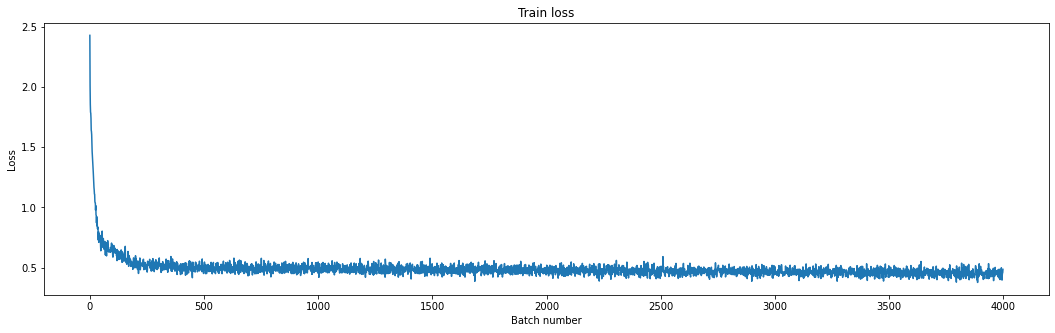

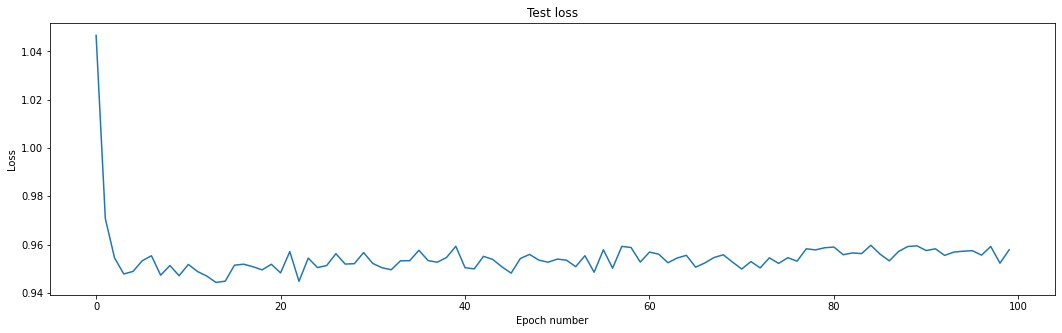

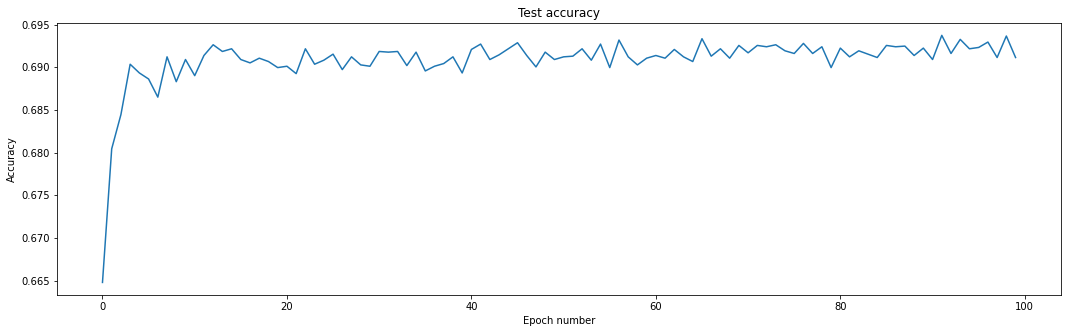

0.4026666666666667


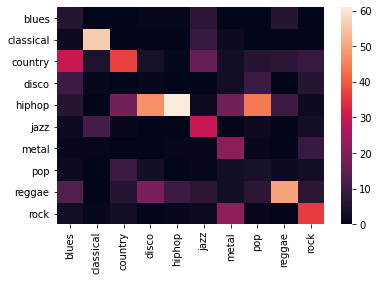

Accuracy test2: 0.38266666666666665


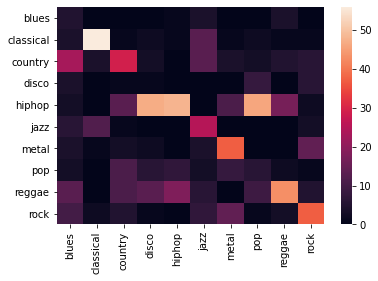

CPU times: user 1min 48s, sys: 1.32 s, total: 1min 49s
Wall time: 1min 52s


In [19]:
%%time
########## Net
seed_init()
scores = []
accuracies = []
classifierNetParams = {'n_hidden':[128, 64,16], 'dropout':0, 'act':'elu'}
# classifierNetParams = {'n_hidden':[256,128,64], 'dropout':0.0, 'act':'elu'}
# classifierNetParams = {'n_hidden':[4096, 1024, 256], 'dropout':0.0, 'act':'elu'}
net = ClassifierNet(**classifierNetParams)
X_train = torch.tensor(X_train_, dtype=torch.float)
y_train = y_train_
X_test = torch.tensor(X_test_, dtype=torch.float)
y_test = y_test_

adam_params = dict(lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
sched_params = dict(milestones=[2*20,9*20,20*20], gamma=0.1)

train_loss, test_loss, test_acc = net.fit(X_train, y_train, X_test, y_test, train_minutes=1, verbose=1, epochs=100,
    verbose_interval=300, opt_params = adam_params, sched_params=sched_params, batch_size=669)

print("Loss: {0}".format(min(test_loss)))
print("Accuracy: {0}".format(accuracy_score(y_test, net.predict(X_test.to(device)))))
plot(train_loss, title='Train loss', xlabel='Batch number', ylabel='Loss')
plot(test_loss, title='Test loss', xlabel='Epoch number', ylabel='Loss')
plot(test_acc, title='Test accuracy', xlabel='Epoch number', ylabel='Accuracy')

X_valid=X_valid_
y_valid=y_valid_
results = net.predict(X_valid)
print(accuracy_score(y_valid, results))
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for valid,res in zip(y_valid, results):
    scores[valid][res] += 1
sns.heatmap(scores)
plt.show()

results = net.predict(X)
print("Accuracy test2: {0}".format(accuracy_score(y, results)))
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for valid,res in zip(y, results):
    scores[valid][res] += 1
sns.heatmap(scores)
plt.show()

### Test best net

Accuracy test: 0.6831818181818182


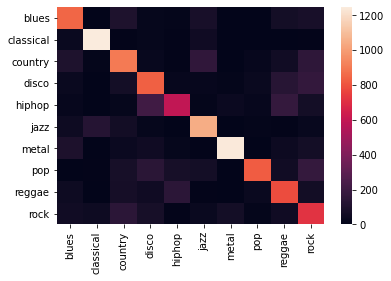

Accuracy valid: 0.444


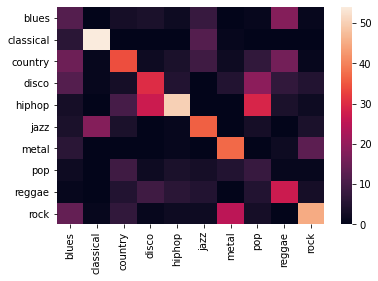

Accuracy test2: 0.43333333333333335


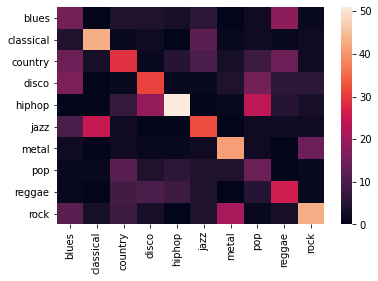

In [20]:
seed_init()
X_valid=X_valid_
y_valid=y_valid_
# net_best = net
net_best = ClassifierNet(**classifierNetParams).to(device)
net_best.load_state_dict(net.best_params['net_state_dict'])

# print("Loss: {0}".format(net.best_loss.item()))
results=net_best.predict(X_test.to(device))
print("Accuracy test: {0}".format(accuracy_score(y_test, results)))
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for test,res in zip(y_test, results):
    scores[test][res] += 1
sns.heatmap(scores)
plt.show()

results = net_best.predict(X_valid)
print("Accuracy valid: {0}".format(accuracy_score(y_valid, results)))
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for valid,res in zip(y_valid, results):
    scores[valid][res] += 1
sns.heatmap(scores)
plt.show()
# print(net.best_params)

results = net_best.predict(X)
print("Accuracy test2: {0}".format(accuracy_score(y, results)))
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for valid,res in zip(y, results):
    scores[valid][res] += 1
sns.heatmap(scores)
plt.show()

In [21]:
net.best_params['loss']

tensor(0.9443)

### Parameters seceltion

In [22]:
# scores = []
# accuracies = []
# valids = []
# params = []
# param_all_pairs = [[nh1,nh2,nh3,dr,lr,ml1,ml2,ml3,gm,ep,bs,act] for nh1,nh2,nh3,lr,ml1,ml2,ml3,gm,ep,bs,act in 
#                    [(128,64,16,1e-2,20,50,90,0.5,200,669,'elu')] for dr in [i/100 for i in range(101)]]
# cnt=1
# for (nh1,nh2,nh3,dr,lr,ml1,ml2,ml3,gm,ep,bs,act) in param_all_pairs: 
#     seed_init()
#     torch.cuda.empty_cache()
    
#     classifierNetParams = {'n_hidden':[nh1,nh2,nh3], 'dropout':dr, 'act':act}
#     net = ClassifierNet(**classifierNetParams)
#     adam_params = dict(lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#     sched_params = dict(milestones=[ml1,ml2,ml3], gamma=gm)

#     train_loss, test_loss, test_acc = net.fit(X_train, y_train, X_test, y_test, train_minutes=1, verbose=0, epochs=ep,
#                             verbose_interval=300, opt_params = adam_params, sched_params=sched_params, batch_size=bs)
    
#     print("#" + str(cnt))
#     cnt+=1
#     params.append("Parameters: n_hidden=[{0},{1},{2}], dropout={3}, lr={4}, milestones=[{5},{6},{7}], gamma={8}, epochs={9}, batch_size={10}, activation={11}"
#                   .format(nh1,nh2,nh3,dr,lr,ml1,ml2,ml3,gm,ep,bs,act))
#     print(params[-1])

# ### Best
#     scores.append(min(test_loss))
#     print("Best loss: {0}".format(scores[-1]))
#     net_best = ClassifierNet(**classifierNetParams).to(device)
#     net_best.load_state_dict(net.best_params['net_state_dict'])
#     accuracies.append(accuracy_score(y_test, net_best.predict(X_test.to(device))))
#     print("Test accuracy: {0}".format(accuracies[-1]))
#     results = net_best.predict(X_valid)
#     valids.append(accuracy_score(y_valid, results))
#     print("Validation accuracy: {0}".format(valids[-1]))
    
# ### Last
#     # scores.append(test_loss[-1])
#     # print("Loss: {0}".format(scores[-1]))
#     # results = net.predict(X_test)
#     # accuracies.append(accuracy_score(y_test, results))
#     # print("Test accuracy: {0}".format(accuracies[-1]))
#     # results = net.predict(X_valid)
#     # valids.append(accuracy_score(y_valid, results))
#     # print("Validation accuracy: {0}".format(valids[-1]))

In [23]:
# torch.save(net.best_params, './net_0.8315_42.66_elu.net')

In [24]:
# gen = net.model.modules()
# arr = gen.__next__()
# print(arr)
# hist(arr[8].weight.cpu().detach().reshape(-1).numpy(), bins=300)
# # assert False

### RFC

In [25]:
# %%time
# dataset = pd.read_csv('../input/gtzan-features/features(scaled)_3_5_10_15_30_rebuilt.csv')
# dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
# X = dataset.drop(columns=['label'])
# Y = dataset.loc[:,'label']
# print(X.shape, Y.shape)
# scores = []
# scores_mx, scores_mn = [], []
# nums = [i for i in range(60, 420, 20)]
# for num in nums:
#     rfc = RandomForestClassifier(n_estimators=num, random_state=SEED)
#     cv_scores = cross_val_score(rfc, X, Y, cv=5, n_jobs=4)
#     scores.append(cv_scores.mean())
#     scores_mn.append(cv_scores.min())
#     scores_mx.append(cv_scores.max())
#     print(str(num) + " " + str(cv_scores.min()) + " " + str(cv_scores.mean()) + " " + str(cv_scores.max()))
# plt.plot(nums, scores)
# plt.plot(nums, scores_mn)
# plt.plot(nums, scores_mx)
# ### D 0.968  0.97   0.972
# ### S 0.9425 0.949  0.953
# ### N 0.946  0.947  0.9495

In [26]:
# %%time
# ########## XGBRFC
# # dataset = pd.read_csv('../input/gtzan-features/features(scaled)_3_5_10_15_30_rebuilt.csv')
# # dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
# # X = dataset.drop(columns=['label'])
# # Y = dataset.loc[:,'label']
# # # pca=PCA(n_components=num, svd_solver='auto', random_state=SEED)
# # # X = pca.fit_transform(X)
# # print(X.shape, Y.shape)
# scores = []
# accuracies = []
# # scores_mx, scores_mn = [], []
# nums = [i for i in range(5,205,5)]
# for num in nums:
#     xgbrfc = XGBRFClassifier(n_estimators=num, random_state=SEED, max_depth=21, eta=0.3, n_jobs=n_jobs, 
#                        subsample=0.7, reg_alpha=0, reg_lambda=num, booster='gbtree', predictor='auto',
#                        tree_method='gpu_hist', eval_metric='mlogloss')
#     xgbrfc.fit(X_train, y_train)
#     preds = xgbrfc.predict_proba(X_test)
#     accuracies.append(accuracy_score(y_test, [genres[x] for x in preds.argmax(axis=1)]))
#     scores.append(log_loss(y_test, preds))
#     print(str(num) + " " + str(scores[-1]) + " " + str(accuracies[-1]))
# plot(nums, scores)
# plot(nums,accuracies)
# #56 - 0.87468671679198 0.877768673776926 0.8806106174527227

### XGBClassifier

In [27]:
%%time
########## XGBC
# dataset = pd.read_csv('../input/gtzan-features/features(scaled)_3_5_10_15_30_rebuilt.csv')
# dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
# X = dataset.drop(columns=['label'])
# Y = dataset.loc[:,'label']
# print(X.shape, Y.shape)
scores = []
accuracies = []
nums = [i for i in range(5,6)]
for num in nums:
    seed_init()
    xgbc = XGBClassifier(n_estimators=50, random_state=SEED, max_depth=num, learning_rate=0.3, n_jobs=n_jobs, 
                       subsample=0.7, reg_alpha=0, reg_lambda=0, booster='gbtree', predictor='auto',
                       tree_method='gpu_hist', eval_metric='mlogloss')
    xgbc.fit(X_train_, y_train)
    preds = xgbc.predict_proba(X_test.cpu().numpy())
    accuracies.append(accuracy_score(y_test, [genres[x] for x in preds.argmax(axis=1)]))
    scores.append(log_loss(y_test, preds))
    print(str(num) + " " + str(scores[-1]) + " " + str(accuracies[-1]))
# plot(nums, scores)
# plot(nums,accuracies)
#lr=0.31+-0.05

5 0.9336151266127743 0.6846212121212121
CPU times: user 4.3 s, sys: 296 ms, total: 4.6 s
Wall time: 4.23 s


In [28]:
# %%time
# scores = []
# # nums = [i for i in range(60,420,20)]
# for num in [1]:
#     dataset = pd.read_csv('../input/gtzan-features/features(scaled)_3_5_10_15_30_rebuilt.csv')[:-999]
#     dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
#     X = dataset.drop(columns=['label'])
#     Y = dataset.loc[:,'label']
# #     classifier = XGBRFClassifier(n_estimators=56, random_state=SEED, max_depth=21, eta=0.3, n_jobs=n_jobs, 
# #                        subsample=0.7, reg_alpha=0, reg_lambda=0, booster='gbtree', predictor='auto',
# #                        tree_method='gpu_hist', eval_metric='mlogloss')
#     classifier = XGBClassifier(n_estimators=180, random_state=SEED, max_depth=6, learning_rate=0.3, n_jobs=n_jobs, 
#                        subsample=0.7, reg_alpha=0, reg_lambda=0, booster='gbtree', predictor='auto',
#                        tree_method='gpu_hist', eval_metric='mlogloss')
#     classifier.fit(X,Y)
#     dataset = pd.read_csv('../input/gtzan-features/features(scaled)_3_5_10_15_30_rebuilt.csv')[-999:]
#     dataset = dataset.sample(frac=1, random_state=SEED*2).reset_index(drop=True)
#     X = dataset.drop(columns=['label'])
#     Y = dataset.loc[:,'label']
#     results = classifier.predict(X)
#     accuracy = accuracy_score(Y, results)
#     scores.append(accuracy)
#     print(str(num) + " " + str(scores[-1]))
# plot(nums, scores)
# ### xgbrfc - 0.97997997997998
# ### xgbc   - 0.995995995995996

### Predict test dataset

0.37866666666666665


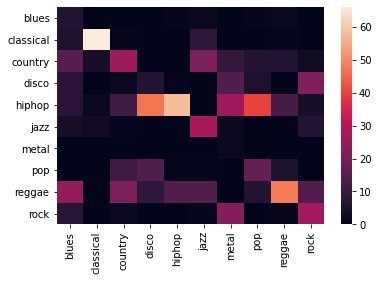

In [29]:
# dataset = pd.read_csv('../input/gtzan-features/features(scaled)_3_5_10_15_30_rebuilt.csv')
# dataset = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
# X_train = dataset.drop(columns=['label'])
# Y_train = dataset.loc[:,'label']
seed_init()
classifier = XGBClassifier(n_estimators=200, random_state=SEED, max_depth=12, learning_rate=0.1, n_jobs=n_jobs, 
                       subsample=0.7, reg_alpha=0, reg_lambda=0, booster='gbtree', predictor='auto',
                       tree_method='gpu_hist', eval_metric='mlogloss')
classifier.fit(X_train_,y_train_)
results = classifier.predict(X)
accuracy = accuracy_score(y, results)
print(accuracy)
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for valid,res in zip(y, results):
#     print(valid,res)
    scores[valid][res] += 1
sns.heatmap(scores)
plt.show()

### Predict test dataset with the trained net

Accuracy: 0.43333333333333335


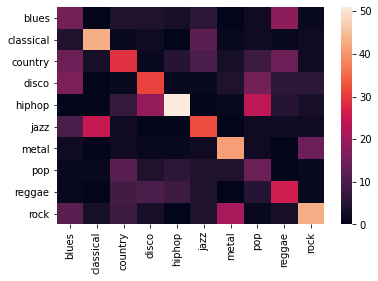

In [30]:
seed_init()
# X_valid=X_valid_
# y_valid=y_valid_
# net_best = net
net_best = ClassifierNet(**classifierNetParams).to(device)
net_best.load_state_dict(net.best_params['net_state_dict'])

results = net_best.predict_proba(X).cpu().data.numpy()
print("Accuracy: {0}".format(accuracy_score(y, [genres[el] for el in np.argmax(results,axis=1)])))
# for i in range(X_valid.shape[0]):
#     results_dataframe = pd.DataFrame([results[i]], columns=genres)
#     print(str(i+1) + "\t" + genres[np.argmax(results[i])] + "\t" + names[i])
#     display(results_dataframe)

results = [genres[el] for el in np.argmax(results,axis=1)]
scores = pd.DataFrame(data=np.zeros((10,10)), index=genres, columns=genres)
for valid,res in zip(y, results):
#     print(valid,res)
    scores[valid][res] += 1
sns.heatmap(scores)
plt.show()

In [31]:
# %%time
# results = classifier.predict_proba(X_valid)
# for i in range(X_valid.shape[0]):
#     results_dataframe = pd.DataFrame([results[i]], columns=genres)
#     print(str(i+1) + "\t" + genres[np.argmax(results[i])] + "\t" + names_valid[i])
#     display(results_dataframe)

In [32]:
# %%time
# extractor = MusicFeaturesExtractor()
# cutter = Cutter()
# loader = Loader()

# data_test, names = loader.load_tracks('../input/musicpack1', get_names=True)
# data_test = extractor.extract(data_test)

In [33]:
# %%time
# results = classifier.predict_proba(data_test)
# for i in range(data_test.shape[0]):
#     results_dataframe = pd.DataFrame([results[i]], columns=genres)
#     print(str(i+1) + "\t" + genres[np.argmax(results[i])] + "\t" + names[i])
#     display(results_dataframe)